In [55]:
from torch import set_grad_enabled, clamp, matmul, Tensor, sum, ones, randn, empty, max, exp, addmm, log
from torch.nn.init import normal_
from random import uniform
from math import pi, sqrt
import matplotlib.pyplot as plt
import random
#%matplotlib notebook

### _I - Setting up_

In [56]:
# Turn off autograd
set_grad_enabled(False)

In [57]:
# Generates a data point sampled uniformly in [0,1]
# If the data is inside the disk centered at (0.5,0.5) of radius 1/2*pi, its label must be 1, else 0
def gen_point():
    center_x, center_y = 0.5, 0.5
    R = 1/sqrt(2*pi)
    rand_x, rand_y = uniform(0, 1), uniform(0, 1)
    label = 0
    if (rand_x - center_x) ** 2 + (rand_y - center_y) ** 2 <= R ** 2: #inside
        label = 1
    return [rand_x, rand_y], label

# Generates N points
def gen_points(N):
    pts = []
    labels = []
    for _ in range(N):
        pt, label = gen_point()
        pts.append(pt)
        labels.append(label)
    return pts, labels


In [58]:
# One-hot encodes y
def convert_to_one_hot(y):
    y_onehot = empty(y.size(0), 2) #2 because boolean one hot
    y_onehot.zero_()
    y_onehot[range(y.size(0)), y.long()] = 1
    return Tensor(y_onehot)

In [59]:
# One-hot decodes y
def decode_one_hot(y_onehot):
    y = empty(y_onehot.size(0))
    y = Tensor([0. if x[0]==1 else 1. for x in y_onehot])
    return y

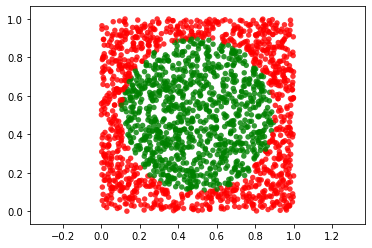

In [60]:
# Generate 1k samples of training data + 1k samples of testing data
all_points, all_labels = gen_points(2000)

# Plot the data
fig, ax = plt.subplots()
plt.axis('equal')
for p,r in zip(all_points, all_labels):
    ax.scatter(p[0], p[1], alpha=0.8, c='green' if r else 'red', edgecolors='none', s=30)

In [61]:
# Convert to tensors
all_points = Tensor(all_points)               # points = datapoint (x and y position)
all_labels = Tensor(all_labels)               # labels = 0 if the point is inside the disk, 1 if outside
all_targets = convert_to_one_hot(all_labels)  # targets = one hot encodings of the labels

# Split the dataset
train_pts, test_pts = all_points[:1000], all_points[1000:]
train_labels, test_labels = all_labels[:1000], all_labels[1000:]
train_targets, test_targets = all_targets[:1000], all_targets[1000:]

In [62]:
# Normalize the datasets
mean,std = train_pts.mean(), train_pts.std()
train_pts.sub_(mean).div_(std)
test_pts.sub_(mean).div_(std)

tensor([[ 1.4263, -0.5731],
        [ 1.3007,  0.5882],
        [ 1.3067, -0.1202],
        ...,
        [ 1.0663, -1.0059],
        [ 1.5137, -0.7622],
        [ 0.3391, -0.2389]])

### _II - Defining network structures_

In [63]:
# Interface
class Module (object):
    def __init__(self):
        self.x = None           # The input to the current module
        self.prev_grad = None   # Gradient at the output of this module
    
    # Forward-pass method
    def forward (self, x):
        raise NotImplementedError
        
    # Backward propagation method
    def backward (self, prev_grad):
        raise NotImplementedError
        
    # Update method
    def step(self, lr):
        raise NotImplementedError

In [64]:
# Fully connected layer
class Linear(Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        
        self.w = randn(in_dim, out_dim) * 0.2 # Random weights from normal dist
        self.b = randn(1, out_dim) * 0.2      # Random bias from normal dist
                                              # Scale with 0.2 not to have inf values and losses
        #print('w', self.w)
        #print('b', self.b)
        
    def forward(self, x):
        self.x = x
        return addmm(self.b, x, self.w)        # Without an activation function
        #return (x @ self.w) + self.b          # Without an activation function
    
    def backward(self, prev_grad):
        self.prev_grad = prev_grad                             # Cache the grad at the output for weight update.      
        current_grad = (prev_grad @ self.w.t()) #+ wd*self.w    # Compute the gradient wrt x with a weight decay
        return current_grad
        
    def step(self, lr):
        self.w -= lr * (self.x.t() @ self.prev_grad)    # Multiply the grad at output with dy/dw to update the weights
        self.b -= lr * (self.prev_grad.sum(dim=0))      # dy/db = 1. then dL / db = dy, which is the grad at the output
    

In [65]:
# Sequential structure to combine several modules
class Sequential(Module):
    def __init__(self, module_list):
        self.module_list = module_list
        
    def forward(self, x):
        out = self.module_list[0].forward(x)
        for module in self.module_list[1:]:
            out = module.forward(out)
        return out
    
    def backward(self, gradwrtoutput):
        for model in self.module_list[::-1]:
            gradwrtoutput = model.backward(gradwrtoutput)
            
    def step(self, lr):
        for module in self.module_list:
            module.step(lr)

### _III - Defining activation functions_

In [66]:
# ReLu activation function
class ReLU(Module):
    
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        self.x = x
        return x.clamp(min = 0)       # Negative values -> 0, positive values stay the same (relu = max(0,x))
    
    def backward(self, prev_grad):
        self.prev_grad = prev_grad    # Cache the gradient at the output 
        curr_grad = prev_grad.clone() # Copy it for returning the new gradient
        curr_grad[self.x < 0] = 0     # Relu = max(0,x), grad_relu = 0 if x <= 0 else 1
        return curr_grad
    
    def step(self, lr):
        pass    

In [81]:
# Tanh activation function
class Tanh(Module):
    
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        self.x = x
        return (exp(x) - exp(-x)) / (exp(x) + exp(-x))                       # Tanh function
    
    def backward(self, prev_grad):
        self.prev_grad = prev_grad                                             # Cache the gradient at the output
        tanh_x = (exp(self.x) - exp(-self.x)) / (exp(self.x) + exp(-self.x))   # Tanh of x
        curr_grad = prev_grad * (1 - (tanh_x)**2)                              # Current gradient 
        return curr_grad
    
    def step(self, lr):
        pass

In [82]:
# Sigmoid activation function
class Sigmoid(Module):
    
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        self.x = x
        return 1 / (1 + exp(-x))                              # Sigmoid function
    
    def backward(self, prev_grad):
        self.prev_grad = prev_grad                            # Cache the gradient at the output 
        sigmoid_x = 1 / (1 + exp(-self.x))                    # Sigmoid of x
        curr_grad = prev_grad * sigmoid_x * (1 - sigmoid_x)   # Current gradient
        return curr_grad

    def step(self, lr):
        pass
    

### _IV - Defining  cost functions_

In [119]:
# Computes the Mean Squared Error & Gradient at output
def mse(pred, target):
    return sum((pred - target)**2),  2* (pred-target)

In [120]:
# Computes the Cross Entropy Loss
def crossEntropyLoss(pred, target):
    return -sum(target*softmax(pred).log()), pred-target

In [187]:
# Softmax function stabilized by taking x = x-max(x)
def softmax(x):
    return exp(x-max(x))/sum(exp(x-max(x)))

### _V - Training and measuring performance_

In [181]:
# Batch generator -> to be implemented in train (+cross validation and grid search)
def data_generator(pts, targets, labels, batch_size):
    data_len = pts.size(0)
    i = 0
    while i < data_len:
        j = i + batch_size if i +batch_size < data_len else data_len
        yield pts[i:j], targets[i:j], labels[i:j]
        i = j

In [73]:
# Instanciates a model with respect to the model id given as input to the function
def model_selector(mid):
    if mid == 0:
        model = Sequential([Linear(2, 25), ReLU(), Linear(25,25), ReLU(),Linear(25,25), ReLU(), Linear(25,2)])
        return model
    elif mid == 1:
        model = Sequential([Linear(2, 25), ReLU(), Linear(25,25), ReLU(),Linear(25,25), ReLU(), Linear(25,2), Sigmoid()])
        return model
    elif mid == 2:
        #model = Sequential([Linear(2, 25), Tanh(), Linear(25,25), Tanh(),Linear(25,25), Tanh(), Linear(25,2), Sigmoid()])
        model = Sequential([Linear(2, 25), ReLU(), Linear(25,25), ReLU(),Linear(25,25), ReLU(), Linear(25,2), Tanh()])
        return model       

In [184]:
# Trains the model over n epochs with mini batch processing
def train(model, train_pts, train_targets, n_epoch, lr,
          test_pts = [], test_targets = [],
          train_history = False, test_history = False, wd = 0, criterion = 'MSE', batch_size = 1000):
    
    # History
    model_history = dict()
    
    # Loss histories
    train_losses = []
    test_losses = []
    
    # Accuracy histories
    train_accs = []
    test_accs = []
    
    # Labels (needed if the accuracies are computed)
    train_labels = []
    test_labels = []
    if (train_history):
        train_labels = decode_one_hot(train_targets)
    if (test_history):
        test_labels = decode_one_hot(test_targets)
    
    # Train for n epochs
    for e in range(n_epoch):
        epoch_train_loss = 0
        #for b in range(0, train_input.size(0), batch_size):
        generator = data_generator(train_pts, train_targets, train_labels, batch_size)
        for i, (t_pts, ts, t_labels) in enumerate(generator):
            train_pred = model.forward(t_pts)
        
            if(criterion=='MSE'):
                train_loss, grad_at_output = mse(train_pred, ts.view(-1, 2))
            elif(criterion=='CROSSENTROPY'):
                train_loss, grad_at_output = crossEntropyLoss(train_pred, ts.view(-1, 2))
            else:
                raise NotImplementedError("Criterion not implemented")
        
            # weight decay (wd*2 if cross entropy?)
            # train_loss += wd * (w**2).sum()/2
        
            model.backward(grad_at_output)             # grad_at_output += wd*w
            model.step(lr)
        
            epoch_train_loss += train_loss.item()
            
            # If we want to keep histories about training loss & accuracy
            if (train_history):
                train_losses.append(train_loss.item())
                train_accs.append(compute_acc(model, t_pts, t_labels, train_pred))
        
        # If we want to keep histories about testing loss & accuracy
        if (test_history):
            
            test_pred = model.forward(test_pts)
            
            if(criterion=='MSE'):
                test_loss, _ = mse(test_pred, test_targets.view(-1, 2))
            elif(criterion=='CROSSENTROPY'):
                test_loss, _ = crossEntropyLoss(test_pred, test_targets.view(-1, 2))
            else:
                raise NotImplementedError("Criterion not implemented")
            
            #test_loss += wd * (w**2).sum()/2
            test_losses.append(test_loss.item())
            test_accs.append(compute_acc(model, test_pts, test_labels, test_pred))

    # If we want to keep histories about training
    if (train_history):
        model_history['train_loss'] = train_losses
        model_history['test_loss'] = test_losses
    
    # If we want to keep histories about testing
    if (test_history):
        model_history['train_accuracy'] = train_accs
        model_history['test_accuracy'] = test_accs
        
    return model_history

In [30]:
# Computes accuracy
def compute_acc(model, pts, labels, pred):
    n_samples = pts.size(0)
    _, indices = max(pred.view(-1,2), 1)
    accuracy = (sum(indices.view(-1,1) == labels.view(-1, 1)) / float(n_samples) * 100).item()
    return accuracy

In [31]:
# Performs a k-fold cross validation
def cross_val_score(mid, train_pts, train_labels, train_targets, n_epoch, lr, k_folds=5):
    len_train = train_pts.size(0)
    indices = [i for i in range(len_train)]
    random.seed(8)
    random.shuffle(indices)
    accs = []
    for k in range(k_folds):
        model = model_selector(mid)  # Init the same model
        val_indices = indices[k*len_train//k_folds:(k+1)*len_train//k_folds] # 1 validation fold
        train_indices = list(set(indices) - set(val_indices))                # k-1 training fold
        
        # Train the model with k-1 training fold
        history = train(model, train_pts[train_indices], train_targets[train_indices], n_epoch, lr)
        
        # Compute the accuracy on 1 validation fold
        acc = compute_acc(model, train_pts[val_indices], train_labels[val_indices], model.forward(train_pts[val_indices])) 
        accs.append(acc)
        #print('fold=', k, ' acc = ', acc)
    return Tensor(accs).mean()

In [60]:
# Grid search for the first model
m_ids = [0]
lrs = [0.00001,0.00002,0.00003,0.00004, 0.00005, 0.00006, 0.00007, 0.00008, 0.00009]
epochs = [50,100,150,200,250]
for mid in m_ids:
    for epoch in epochs:
        for lr in lrs:
            avg = cross_val_score(mid, train_pts, train_labels, train_targets, epoch, lr)
            print(mid, lr, epoch, avg)

0 1e-05 50 tensor(61.8000)
0 2e-05 50 tensor(68.5000)
0 3e-05 50 tensor(75.2000)
0 4e-05 50 tensor(75.3000)
0 5e-05 50 tensor(84.6000)
0 6e-05 50 tensor(82.4000)
0 7e-05 50 tensor(85.9000)
0 8e-05 50 tensor(88.9000)
0 9e-05 50 tensor(89.1000)
0 1e-05 100 tensor(70.6000)
0 2e-05 100 tensor(83.)
0 3e-05 100 tensor(82.4000)
0 4e-05 100 tensor(81.6000)
0 5e-05 100 tensor(93.5000)
0 6e-05 100 tensor(90.6000)
0 7e-05 100 tensor(95.8000)
0 8e-05 100 tensor(95.1000)
0 9e-05 100 tensor(95.2000)
0 1e-05 150 tensor(71.2000)
0 2e-05 150 tensor(84.1000)
0 3e-05 150 tensor(88.4000)
0 4e-05 150 tensor(93.6000)
0 5e-05 150 tensor(93.1000)
0 6e-05 150 tensor(96.6000)
0 7e-05 150 tensor(96.9000)
0 8e-05 150 tensor(96.1000)
0 9e-05 150 tensor(96.)
0 1e-05 200 tensor(77.4000)
0 2e-05 200 tensor(89.1000)
0 3e-05 200 tensor(93.1000)
0 4e-05 200 tensor(94.6000)
0 5e-05 200 tensor(97.6000)
0 6e-05 200 tensor(96.6000)
0 7e-05 200 tensor(97.4000)
0 8e-05 200 tensor(97.5000)
0 9e-05 200 tensor(96.7000)
0 1e-05 2

In [61]:
# Grid search for the second model (sigmoid)
m_ids = [1]
lrs = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009]
epochs = [50,100,150,200,250]

for mid in m_ids:
    for epoch in epochs:
        for lr in lrs:
            avg = cross_val_score(mid, train_pts, train_labels, train_targets, epoch, lr)
            print(mid, lr, epoch, avg)

1 0.001 50 tensor(82.)
1 0.002 50 tensor(78.4000)
1 0.003 50 tensor(80.6000)
1 0.004 50 tensor(81.2000)
1 0.005 50 tensor(80.9000)
1 0.006 50 tensor(83.)
1 0.007 50 tensor(81.)
1 0.008 50 tensor(59.9000)
1 0.009 50 tensor(67.1000)
1 0.001 100 tensor(83.8000)
1 0.002 100 tensor(92.6000)
1 0.003 100 tensor(92.8000)
1 0.004 100 tensor(93.1000)
1 0.005 100 tensor(94.4000)
1 0.006 100 tensor(89.8000)
1 0.007 100 tensor(91.1000)
1 0.008 100 tensor(88.2000)
1 0.009 100 tensor(73.1000)
1 0.001 150 tensor(93.6000)
1 0.002 150 tensor(90.5000)
1 0.003 150 tensor(91.3000)
1 0.004 150 tensor(94.2000)
1 0.005 150 tensor(92.7000)


KeyboardInterrupt: 

In [ ]:
# Grid search for the third model (tanh)
m_ids = [2]
lrs = [0.00001,0.00002,0.00003,0.00004, 0.00005, 0.00006, 0.00007, 0.00008, 0.00009]
epochs = [50,100,150,200,250]
for mid in m_ids:
    for epoch in epochs:
        for lr in lrs:
            avg = cross_val_score(mid, train_pts, train_res,train_target, epoch, lr)
            print(mid, lr, epoch, avg)

In [193]:
# Test the performance of the sigmoid model with tuned hyper parameters 
model_sigmoid = model_selector(1)
history_sigmoid = train(model_sigmoid, train_pts, train_targets, 250, 0.004,
                        test_pts = test_pts, test_targets = test_targets, train_history = True, test_history = True, criterion='CROSSENTROPY', batch_size=300)
acc_sigmoid = compute_acc(model_sigmoid, test_pts, test_labels, model_sigmoid.forward(test_pts))
print(acc_sigmoid)

98.0999984741211


In [152]:
# Test the performance of the other model with tuned hyper parameters
model_relu = model_selector(0)
history_relu = train(model_relu, train_pts, train_targets, 250, 0.00005,
                        test_pts = test_pts, test_targets = test_targets, train_history = True, test_history = True, criterion='MSE')
acc_relu = compute_acc(model_relu, test_pts, test_labels, model_relu.forward(test_pts))
print(acc_relu)

94.19999694824219


In [102]:
# Test the performance of the other model with tuned hyper parameters
model_tanh = model_selector(2)
history_tanh = train(model_tanh, train_pts, train_targets, 250, 0.00005,
                        test_pts = test_pts, test_targets = test_targets, train_history = True, test_history = True, criterion='MSE')
acc_tanh = compute_acc(model_tanh, test_pts, test_labels, model_tanh.forward(test_pts))
print(acc_tanh)

94.9000015258789


### _VI - Plots_

In [56]:
def plot_loss(history, model_name, train_history = False, test_history = False):
    train_losses = history['train_loss']
    test_losses = history['test_loss']
    plt.figure(figsize=(10,8))
    
    if (train_history):
        plt.plot(train_losses, label = model_name + " Training Loss")
            
    if (test_history):
        plt.plot(test_losses, label =  model_name + " Testing Loss")
            
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [57]:
def plot_acc(history, model_name, train_history = False, test_history = False):
    train_accs = history['train_accuracy']
    test_accs = history['test_accuracy']
    plt.figure(figsize=(10,8))
    
    if (train_history):
        plt.plot(train_accs, label =  model_name + " Training Accuracy")
            
    if (test_history):
        plt.plot(test_accs, label =  model_name + " Testing Accuracy")
            
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

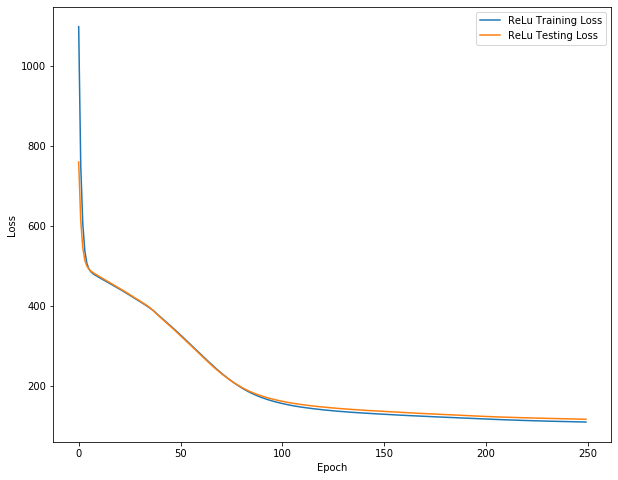

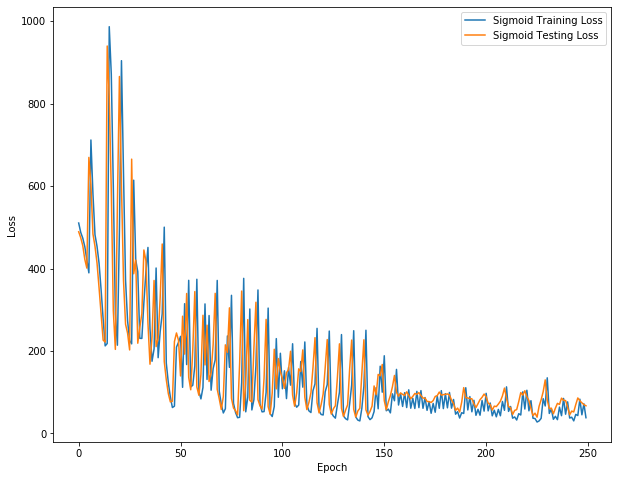

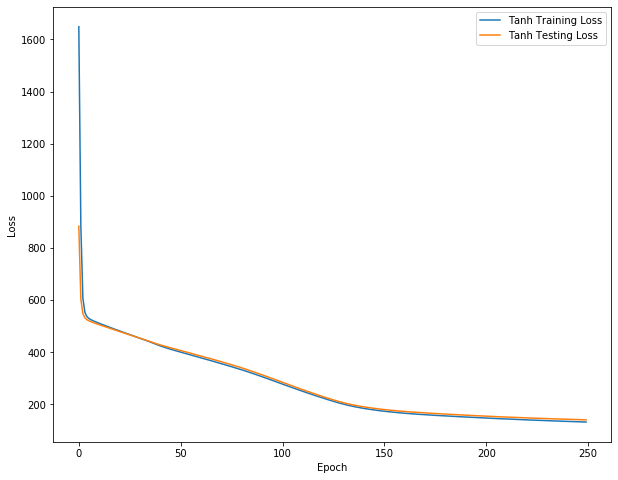

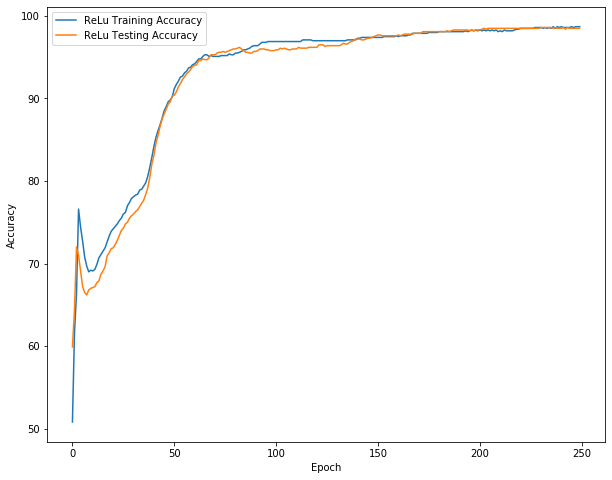

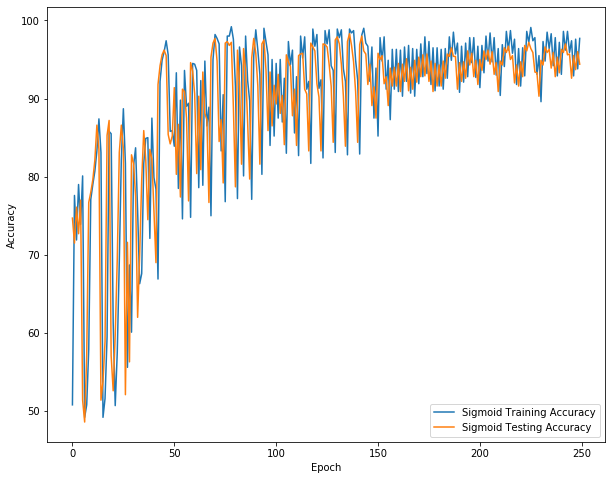

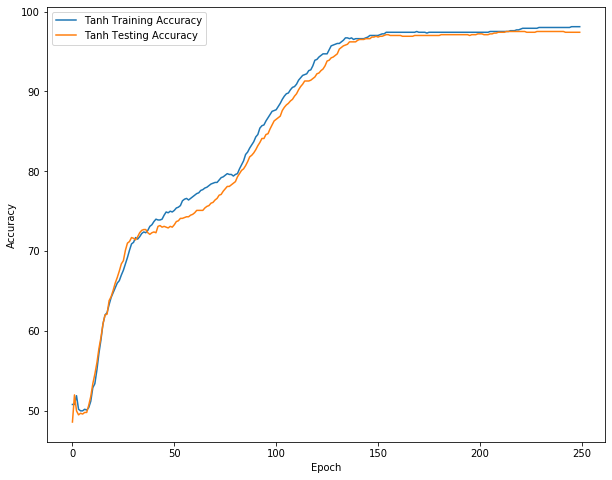

In [58]:
plot_loss(history_relu, 'ReLu', train_history = True, test_history = True)
plot_loss(history_sigmoid, 'Sigmoid', train_history = True, test_history = True)
plot_loss(history_tanh, 'Tanh', train_history = True, test_history = True)
plot_acc(history_relu, 'ReLu', train_history = True, test_history = True)
plot_acc(history_sigmoid, 'Sigmoid', train_history = True, test_history = True)
plot_acc(history_tanh, 'Tanh', train_history = True, test_history = True)